<a href="https://colab.research.google.com/github/jcalandra/audiosynthesis_dl/blob/master/src/Pict2Audio_son.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pict2Audio : A Neural Network that associates Pictures to Audio Descriptors
This project consists in associating a sound with one or more characteristics defined by audio descriptors with a picture drawn by a composer . The long-term goal is to allow the composer to develop his own composition graphic language in order to associate it with sounds from some effects banks.

 
 ## Sound classification

In this study, I'm interested into pitch, volume and tone color features, and I will propose as input to a Convolutional Neural Network trained for classification a database composed of :
* sounds from the audio libraries of the composer,
* three labels for each audio, corresponding to the features in the labels associated to sound features. 

## Importation of the python librairies

In [0]:
print('[INFO] loading the librairies...')
from __future__ import print_function
import os
import glob

import numpy as np
from random import shuffle
import matplotlib
import matplotlib.pyplot as plt

import librosa
from librosa import display

import tensorflow as tf
import keras
from keras.models import Sequential
from keras import optimizers, losses, activations, models
from keras.optimizers import RMSprop
from keras import callbacks
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Input, Dropout, Activation, BatchNormalization, Conv2D, MaxPooling2D, GlobalMaxPool2D, Flatten
print('tensorflow:', tf.__version__)
print('keras:', keras.__version__)

In [0]:
! git clone https://github.com/jcalandra/audiosynthesis_dl.git

In [0]:
NB_PITCH = 12
NB_THICK = 5
NB_COLOR = 8
NB_CARACTERISTICS = 4

SAMPLE_RATE = 16000
INPUT_LENGTH = SAMPLE_RATE*4
batch_size = 32
NB_MELS = 320
MAX = 50 # trouver une valeur adaptée

## Processing MelSpectrograms

In [0]:
def preprocess_audio_mel(audio, sample_rate=SAMPLE_RATE, window_size=20, #log_specgram
                 step_size=10, eps=1e-10):

  mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels= NB_MELS)
  mel_db = (librosa.power_to_db(mel_spec, ref=MAX) + 80)/80

  return mel_db


def load_audio_file(file_path, input_length=INPUT_LENGTH):
  data = librosa.core.load(file_path, sr=SAMPLE_RATE)[0] #, sr=16000
  if len(data)>input_length:
    max_offset = len(data)-input_length       
    offset = np.random.randint(max_offset)     
    data = data[offset:(input_length+offset)]          
  else:
    if input_length > len(data):
      max_offset = input_length - len(data)
      offset = np.random.randint(max_offset)
    else:
      offset = 0           
      data = np.pad(data, (offset, input_length - len(data) - offset), "constant") #remarque : p-e qu'on veut ajouter du silence plutôt ? dépend du type de son
  data = preprocess_audio_mel(data)
  return data
 
  
def generate_mels(snd_tab):
  x_tab = np.empty((len(snd_tab),NB_MELS,126, 1))
  for i in range(len(snd_tab)) :
    x_tab_i = np.reshape(load_audio_file(snd_tab[i]),(1,NB_MELS,126,1))
    x_tab[i] = x_tab_i
  return x_tab

In [0]:
snd_train = glob.glob("./audiosynthesis_dl/data/bdd_snd/snd_train/*.wav") #train_files
snd_validation = glob.glob("./audiosynthesis_dl/data/bdd_snd/snd_validation/*.wav") 

NB_TRAIN = len(snd_train)
NB_VALIDATION = len(snd_validation)

print(snd_train)
print(NB_TRAIN)

In [0]:
print('[INFO] generation of train mel spectrograms...')
x_train = generate_mels(snd_train)
print('[INFO] generation of validation mel spectrograms...')
x_validation = generate_mels(snd_validation)

# il faut des valeurs positives non ?
print(x_train)
print(len(x_train))

print('x_train.shape =', x_train.shape)

## Processing Labels

In [0]:
def create_label_tab(sndPath_tab):
  """create a tab of labels considering a tab of filenames filenames_tab"""
  labels_tab = []
  for sndP in sndPath_tab:
    snd = sndP.split('.')[0]
    l = snd.split("-")
    labels = l[:NB_CARACTERISTICS]
    labels_tab.append(labels)
  return labels_tab

def gen_features_tabs(y_tab, y_feature, i_feature) :
  ''' generate a tab containing the labels for one specific feature '''
  for i in range(len(y_tab)) :
    y_feature[i] = y_tab[i][i_feature]

In [0]:
sndPath_train = os.listdir( "./audiosynthesis_dl/data/bdd_snd/snd_train")[:]
sndPath_validation = os.listdir( "./audiosynthesis_dl/data/bdd_snd/snd_validation")[:]

label_train = create_label_tab(sndPath_train)
label_validation = create_label_tab(sndPath_validation)

print(label_train)
print(label_validation)

In [0]:
# converts into int between 0 and n

def label2int(label_tab):
  """converts the label tab into int between 0 and n """
  y_tab = []
  for i in range(len(label_tab)):
    label_tab_i = []
    #pitch labelisation
    pitch = int(label_tab[i][1]) - 69
    #thick labelisation
    label_thick = label_tab[i][3]
    if(label_thick == 'low'):
      thick = 0
    elif (label_thick == 'med'):
      thick = 1
    else :
      thick = 2
    #color labelisation
    #TODO : adapter à 8 couleurs
    label_color = label_tab[i][0].split('_')[0]
    if (label_color == 'brass'):
      color = 0
    elif (label_color == 'guitar'):
      color = 1
    elif (label_color == 'keyboard'):
      color = 2
    elif (label_color == 'organ'):
      color = 3
    elif (label_color == 'string'):
      color = 4
    elif (label_color == 'vocal'):
      color = 5
    elif (label_color == 'flute'):
      color = 6
    else :
      color = 7    
    label_tab_i.append(color)
    label_tab_i.append(pitch)
    label_tab_i.append(thick)
    y_tab.append(label_tab_i)  
  return y_tab

In [0]:
print('[INFO] convertion of train labels into int...')
y_train = label2int(label_train)
print('[INFO] convertion of validation labels into int...')
y_validation = label2int(label_validation)

print(y_train)
print(y_validation)

In [0]:
## GENERATION OF THE PITCH FEATURES TABS

print('[INFO] generation of the pitch features tabs...')
y_train_pitch = np.empty(NB_TRAIN)
y_validation_pitch = np.empty(NB_VALIDATION)

gen_features_tabs(y_train, y_train_pitch, 1)
gen_features_tabs(y_validation, y_validation_pitch, 1)

print(y_train_pitch)
print(y_validation_pitch)

# Convert class vectors to binary class matrices ("one hot encoding")
print('[INFO] converting pitch class vectors...')
y_train_pitch = keras.utils.to_categorical(y_train_pitch, NB_PITCH)
y_validation_pitch = keras.utils.to_categorical(y_validation_pitch, NB_PITCH)

print('y_train_pitch.shape =', y_train_pitch.shape)
print('y_validation_pitch.shape =', y_validation_pitch.shape)

## Plot the Mel Spectrogram

In [0]:
print(snd_test)

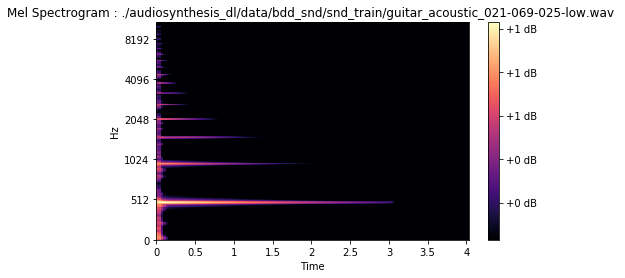

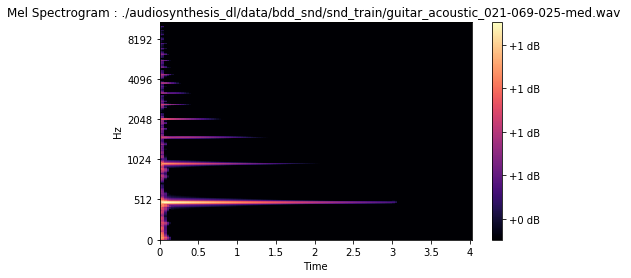

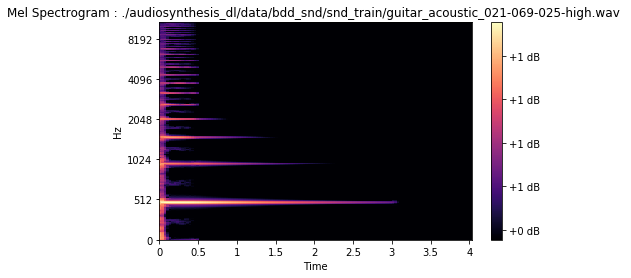

In [62]:
## PLOT THE MELSPECTROGRAM
#TODO : trouver un meilleur affichage car on croirait avoir les même valeurs
#pour low et med (les valeurs des spectrogrammes sont effectivement différentes 
#- voir les échelles) ou alors les tons pour low deviennent dans les bleus qd MAX >env60

ind1 = './audiosynthesis_dl/data/bdd_snd/snd_train/guitar_acoustic_021-069-025-low.wav'

data_base = load_audio_file(ind1)
fig = plt.figure(figsize=(7, 4))
plt.title('Mel Spectrogram : %s ' % (ind1))
librosa.display.specshow(data_base, sr=SAMPLE_RATE, x_axis='time', y_axis='mel')
plt.colorbar(format='%+02.0f dB')

ind2 = './audiosynthesis_dl/data/bdd_snd/snd_train/guitar_acoustic_021-069-025-med.wav'
data_base = load_audio_file(ind2)
fig = plt.figure(figsize=(7, 4))
plt.title('Mel Spectrogram : %s ' % (ind2))
librosa.display.specshow(data_base, sr=SAMPLE_RATE, x_axis='time', y_axis='mel')
plt.colorbar(format='%+02.0f dB')

ind3 = './audiosynthesis_dl/data/bdd_snd/snd_train/guitar_acoustic_021-069-025-high.wav'
data_base = load_audio_file(ind3)
fig = plt.figure(figsize=(7, 4))
plt.title('Mel Spectrogram : %s ' % (ind3))
librosa.display.specshow(data_base, sr=SAMPLE_RATE, x_axis='time', y_axis='mel')
plt.colorbar(format='%+02.0f dB')

## Training the Neural Networks

### Pitch Convolutional Neural Network

In [0]:
## CREATION OF THE NEURAL NETWORK

model_pitch = Sequential()

model_pitch.add(Conv2D(filters=32, kernel_size=(3,3), strides=1, padding='valid', activation='relu'))
model_pitch.add(BatchNormalization(axis=-1))
model_pitch.add(MaxPooling2D(pool_size=(3,3), strides=None, padding='valid', data_format=None))
              
# (CONV => RELU) * 2 => POOL
model_pitch.add(Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='valid', activation='relu'))
model_pitch.add(BatchNormalization(axis=-1))
model_pitch.add(Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='valid', activation='relu'))
model_pitch.add(BatchNormalization(axis=-1))
model_pitch.add(MaxPooling2D(pool_size=(2,2), strides=None, padding='valid', data_format=None))

# (CONV => RELU) * 2 => POOL
model_pitch.add(Conv2D(filters=128, kernel_size=(3,3), strides=1, padding='valid', activation='relu'))
model_pitch.add(BatchNormalization(axis=-1))
model_pitch.add(Conv2D(filters=128, kernel_size=(3,3), strides=1, padding='valid', activation='relu'))
model_pitch.add(BatchNormalization(axis=-1))
model_pitch.add(MaxPooling2D(pool_size=(2,2), strides=None, padding='valid', data_format=None))
model_pitch.add(Dropout(rate=0.2))

model_pitch.add(Conv2D(filters=256, kernel_size=(3,3), strides=1, padding='valid', activation='relu'))
model_pitch.add(BatchNormalization(axis=-1))
model_pitch.add(Conv2D(filters=256, kernel_size=(3,3), strides=1, padding='valid', activation='relu'))
model_pitch.add(BatchNormalization(axis=-1))
model_pitch.add(MaxPooling2D(pool_size=(2,2), strides=None, padding='valid', data_format=None))
model_pitch.add(Dropout(rate=0.2))

# first (and only) set of FC => RELU layers
model_pitch.add(Flatten())
model_pitch.add(Dense(1024))
model_pitch.add(Activation("relu"))
model_pitch.add(BatchNormalization())
model_pitch.add(Dropout(rate=0.5))
 
# use a *sigmoid* activation for multi-label classification
model_pitch.add(Dense(NB_PITCH))
model_pitch.add(Activation('softmax'))

opt_pitch = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model_pitch.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cb = callbacks.ModelCheckpoint('model_pitchsnd.h5', save_best_only=True, period=1)
#model.load_weights("baseline_cnn.h5")

hist_pitch = model_pitch.fit(x_train, y_train_pitch, validation_data=(x_validation, y_validation_pitch), epochs=100, batch_size = 32, callbacks=[cb])
loss_and_metrics_pitch = model_pitch.evaluate(x_validation, y_validation_pitch, batch_size=32)
print('loss =', loss_and_metrics_pitch[0],'accuracy =', loss_and_metrics_pitch[1]);

model_pitch.summary();

In [0]:
# summarize history for accuracy
plt.plot(hist_pitch.history['acc'])
plt.plot(hist_pitch.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['pitch train', 'pitch validation'], loc='lower right')
plt.show()

# summarize history for loss
plt.plot(hist_pitch.history['loss'])
plt.plot(hist_pitch.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['pitch train', 'pitch validation'], loc='upper right')
plt.show()


del y_train_pitch
del y_validation_pitch

résults : 
* C2D(32)+2xC2D(64)+2xC2D(128)+Dropout(0.2)+2xC2D(264)+Dropout(0.2)+dense(1024)+Dropout(0.5)
* epoch = 100, batch size = 32, opt adam
* loss: 4.9768e-05 - acc: 1.0000 - val_loss: 0.6577 - val_acc: 0.9310

### thick convolutional network

In [63]:
## GENERATION OF THE THICK==VOLUME FEATURES TABS

print('[INFO] generation of the thick features tabs...')
y_train_thick = np.empty(NB_TRAIN)
y_validation_thick = np.empty(NB_VALIDATION)

gen_features_tabs(y_train, y_train_thick, 2)
gen_features_tabs(y_validation, y_validation_thick, 2)

print('[INFO] converting thick class vectors...')
y_train_thick = keras.utils.to_categorical(y_train_thick, NB_THICK)
y_validation_thick = keras.utils.to_categorical(y_validation_thick, NB_THICK)

print('y_train_thick.shape =', y_train_thick.shape)
print('y_validation_thick.shape =', y_validation_thick.shape)

[INFO] generation of the thick features tabs...
[INFO] converting thick class vectors...
y_train_thick.shape = (282, 5)
y_validation_thick.shape = (87, 5)


In [0]:
## CREATION OF THE THICK NEURAL NETWORK

model_thick = Sequential()

model_thick.add(Conv2D(filters=32, kernel_size=(3,3), strides=1, padding='valid', activation='relu'))
model_thick.add(BatchNormalization(axis=-1))
model_thick.add(MaxPooling2D(pool_size=(3,3), strides=None, padding='valid', data_format=None))
              
# (CONV => RELU) * 2 => POOL
model_thick.add(Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='valid', activation='relu'))
model_thick.add(BatchNormalization(axis=-1))
model_thick.add(Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='valid', activation='relu'))
model_thick.add(BatchNormalization(axis=-1))
model_thick.add(MaxPooling2D(pool_size=(2,2), strides=None, padding='valid', data_format=None))

# (CONV => RELU) * 2 => POOL
model_thick.add(Conv2D(filters=128, kernel_size=(3,3), strides=1, padding='valid', activation='relu'))
model_thick.add(BatchNormalization(axis=-1))
model_thick.add(Conv2D(filters=128, kernel_size=(3,3), strides=1, padding='valid', activation='relu'))
model_thick.add(BatchNormalization(axis=-1))
model_thick.add(MaxPooling2D(pool_size=(2,2), strides=None, padding='valid', data_format=None))

model_thick.add(Conv2D(filters=256, kernel_size=(3,3), strides=1, padding='valid', activation='relu'))
model_thick.add(BatchNormalization(axis=-1))
model_thick.add(Conv2D(filters=256, kernel_size=(3,3), strides=1, padding='valid', activation='relu'))
model_thick.add(BatchNormalization(axis=-1))
model_thick.add(MaxPooling2D(pool_size=(2,2), strides=None, padding='valid', data_format=None))

# first (and only) set of FC => RELU layers
model_thick.add(Flatten())
model_thick.add(Dense(1024))
model_thick.add(Activation("relu"))
model_thick.add(BatchNormalization())
 
# use a *sigmoid* activation for multi-label classification
model_thick.add(Dense(NB_THICK))
model_thick.add(Activation('softmax'))

model_thick.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cb = callbacks.ModelCheckpoint('model_thicksnd.h5', save_best_only=True, period=1)
#model.load_weights("baseline_cnn.h5")

hist_thick = model_thick.fit(x_train, y_train_thick, validation_data=(x_validation, y_validation_thick), epochs=100, batch_size = 32, callbacks=[cb])
loss_and_metrics_thick = model_thick.evaluate(x_validation, y_validation_thick, batch_size=32)
print('loss =', loss_and_metrics_thick[0],'accuracy =', loss_and_metrics_thick[1]);

model_thick.summary();

In [0]:
# summarize history for accuracy
plt.plot(hist_thick.history['acc'])
plt.plot(hist_thick.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['thick train', 'thick validation'], loc='lower right')
plt.show()

# summarize history for loss
plt.plot(hist_thick.history['loss'])
plt.plot(hist_thick.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['thick train', 'thick validation'], loc='upper right')
plt.show()


del y_train_thick
del y_validation_thick

résults : 
* 2xC2D(32)+2xC2D(64)+3xC2D(128)+2xC2D(264)+dense(1024)
* epoch = 100, batch size = 32, opt adam
* loss: 0.5038 - acc: 0.6064 - val_loss: 0.5148 - val_acc: 0.6552

### color convolutional neural network


In [0]:
## GENERATION OF THE COLOR==TONE FEATURES TABS

print('[INFO] generation of the color features tabs...')
y_train_color = np.empty(NB_TRAIN)
y_validation_color = np.empty(NB_VALIDATION)

gen_features_tabs(y_train, y_train_color, 0)
gen_features_tabs(y_validation, y_validation_color, 0)

print('[INFO] converting color class vectors...')
y_train_color = keras.utils.to_categorical(y_train_color, NB_COLOR)
y_validation_color = keras.utils.to_categorical(y_validation_color, NB_COLOR)

In [0]:
## CREATION OF THE COLOR NEURAL NETWORK

model_color = Sequential()

model_color.add(Conv2D(filters=32, kernel_size=(3,3), strides=1, padding='valid', activation='relu'))
model_color.add(BatchNormalization(axis=-1))
model_color.add(MaxPooling2D(pool_size=(3,3), strides=None, padding='valid', data_format=None))
              
# (CONV => RELU) * 2 => POOL
model_color.add(Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='valid', activation='relu'))
model_color.add(BatchNormalization(axis=-1))
model_color.add(Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='valid', activation='relu'))
model_color.add(BatchNormalization(axis=-1))
model_color.add(MaxPooling2D(pool_size=(2,2), strides=None, padding='valid', data_format=None))

# (CONV => RELU) * 2 => POOL
model_color.add(Conv2D(filters=128, kernel_size=(3,3), strides=1, padding='valid', activation='relu'))
model_color.add(BatchNormalization(axis=-1))
model_color.add(Conv2D(filters=128, kernel_size=(3,3), strides=1, padding='valid', activation='relu'))
model_color.add(BatchNormalization(axis=-1))
model_color.add(MaxPooling2D(pool_size=(2,2), strides=None, padding='valid', data_format=None))

model_color.add(Conv2D(filters=256, kernel_size=(3,3), strides=1, padding='valid', activation='relu'))
model_color.add(BatchNormalization(axis=-1))
model_color.add(Conv2D(filters=256, kernel_size=(3,3), strides=1, padding='valid', activation='relu'))
model_color.add(BatchNormalization(axis=-1))
model_color.add(MaxPooling2D(pool_size=(2,2), strides=None, padding='valid', data_format=None))

# first (and only) set of FC => RELU layers
model_color.add(Flatten())
model_color.add(Dense(1024))
model_color.add(Activation("relu"))
model_color.add(BatchNormalization())
model_color.add(Dropout(rate=0.5))
 
# use a *sigmoid* activation for multi-label classification
model_color.add(Dense(NB_COLOR))
model_color.add(Activation('softmax'))

opt_color= keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model_color.compile(loss='categorical_crossentropy', optimizer=opt_color, metrics=['accuracy'])
cb = callbacks.ModelCheckpoint('model_colorsnd.h5', save_best_only=True, period=1)
#model.load_weights("baseline_cnn.h5")

hist_color = model_color.fit(x_train, y_train_color, validation_data=(x_validation, y_validation_color), epochs=100, batch_size = 32, callbacks=[cb])
loss_and_metrics_color = model_color.evaluate(x_validation, y_validation_color, batch_size=32)
print('loss =', loss_and_metrics_color[0],'accuracy =', loss_and_metrics_color[1]);

model_color.summary();

In [0]:
# summarize history for accuracy
plt.plot(hist_color.history['acc'])
plt.plot(hist_color.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['color train', 'color validation'], loc='lower right')
plt.show()

# summarize history for loss
plt.plot(hist_color.history['loss'])
plt.plot(hist_color.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['color train', 'color validation'], loc='upper right')
plt.show()

del y_train_color
del y_validation_color

résults :

* C2D(32)+2xC2D(64)+2xC2D(128)+2xC2D(264)+dense(1024)+Dropout(0.5)
* epoch = 100, batch size = 32, opt adam
* 154ms/step - loss: 1.2560e-04 - acc: 1.0000 - val_loss: 0.0025 - val_acc: 1.0000

## Test

In [0]:
def test_accuracy(y_tab, y_guessed):
  accuracy_sum = 0
  for i in range(len(y_tab)) :
    if(y_tab[i] == y_guessed[i]):
      accuracy_sum += 1
  accuracy = float(accuracy_sum) / float(len(y_guessed))
  print('accuracy = ', accuracy)

In [0]:
snd_test = glob.glob("./audiosynthesis_dl/data/bdd_snd/snd_test/*.wav") #test_files
NB_TEST = len(snd_test)

print('[INFO] generation of test mel spectrograms...')
x_test = generate_mels(snd_test)

sndPath_test = os.listdir( "./audiosynthesis_dl/data/bdd_snd/snd_test")[:]
label_test = create_label_tab(sndPath_test)
print(label_test)

print('[INFO] convertion of test labels into int...')
y_teststat = label2int(label_test)
print(y_teststat)

y_teststat_pitch = np.empty(NB_TEST)
gen_features_tabs(y_teststat, y_teststat_pitch, 1)
print(y_teststat_pitch)

y_teststat_thick = np.empty(NB_TEST)
gen_features_tabs(y_teststat, y_teststat_thick, 2)

y_teststat_color = np.empty(NB_TEST)
gen_features_tabs(y_teststat, y_teststat_color, 0)

In [0]:
print("[INFO] loading networks...")
model_pitch = load_model('model_pitchsnd.h5')
model_thick = load_model('model_thicksnd.h5')
model_color = load_model('model_colorsnd.h5')

y_test_pitch = model_pitch.predict_classes(x_test)
y_test_thick = model_thick.predict_classes(x_test)
y_test_color = model_color.predict_classes(x_test)

# show the inputs and predicted outputs
for i in range(len(y_test_pitch)):
  print("label y_test_pitch[%s] = %s, label y_teststat_pitch[%s] = %s " % (i, y_test_pitch[i], i, y_teststat_pitch[i]))
  print("label y_test_thick[%s] = %s, label y_teststat_thick[%s] = %s " % (i, y_test_thick[i], i, y_teststat_thick[i]))
  print("label y_test_color[%s] = %s, label y_teststat_color[%s] = %s \n" % (i, y_test_color[i], i, y_teststat_color[i]))
  
print('pitch :')
test_accuracy(y_teststat_pitch, y_test_pitch)
print('thick :')
test_accuracy(y_teststat_thick, y_test_thick)
print('color :')
test_accuracy(y_teststat_color, y_test_color)